# pix2pix: Image-to-image translation with a conditional GAN

## Import TensorFlow and other libraries

In [1]:
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
import numpy as np
import datetime
import pathlib
import time
import cv2
import os
from utils import *
from discriminator import *
from generator import *

In [2]:
log_dir="../logs/CoCo_256_baseline_night/"
image_dir="../training_img/CoCo_256_baseline_night/"
checkpoint_dir = '../training_checkpoints/CoCo_256_baseline_night/'

# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256


summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

path_to_dataset = pathlib.Path('../dataset/')
PATH = path_to_dataset


#### Load the dataset


In [3]:
#Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


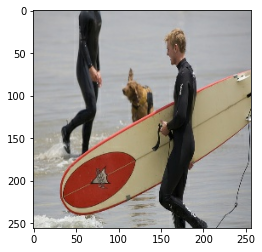

In [4]:
sample_image = tf.io.read_file(str(PATH/'train/1.jpg'))
sample_image = tf.image.decode_jpeg(sample_image)

plt.imshow(sample_image)

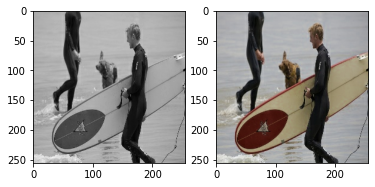

In [5]:
inp, re = load(str(PATH / 'train/1.jpg'))
# Casting to int for matplotlib to display the images

img = tf.keras.layers.Concatenate()([re, inp])
img = tf.image.hsv_to_rgb(img/255.0)

plt.subplot(1,2,1)
plt.imshow(inp / 255.0, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img)

#### Build an input pipeline with `tf.data`

In [6]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [7]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
  
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

#### Build the generator & Dsicriminator


In [8]:
generator = Generator(img_width=IMG_WIDTH, img_height=IMG_HEIGHT)
discriminator = Discriminator(img_width=IMG_WIDTH, img_height=IMG_HEIGHT)

#### Define a checkpoint-saver


In [9]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator.optimizer,
                                 discriminator_optimizer=discriminator.optimizer,
                                 generator=generator.generator,
                                 discriminator=discriminator.discriminator)

#### Training loop

In [10]:
@tf.function
def train_step(input_image, target, step, length):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator.generator(input_image, training=True)

    disc_real_output = discriminator.discriminator([input_image, target], training=True)
    disc_generated_output = discriminator.discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator.loss(disc_generated_output, gen_output, target)

    disc_loss = discriminator.loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.discriminator.trainable_variables)

  generator.optimizer.apply_gradients(zip(generator_gradients,
                                          generator.generator.trainable_variables))
  discriminator.optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//length)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//length)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//length)
    tf.summary.scalar('disc_loss', disc_loss, step=step//length)

In [11]:
def fit(train_ds, test_ds, epochs, load_checkpoint=False):
  time_interval = int(len(train_ds)/100)
  print_interval = int(len(train_ds)/ BATCH_SIZE)
  save_interval = int(len(train_ds) * 5/ BATCH_SIZE)
  if load_checkpoint:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  example_imgs = test_ds.take(10)
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(int(epochs * len(train_ds))).enumerate():
    if (step) % print_interval == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1 Epoch: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images2(generator.generator, example_imgs, image_dir)
      print(f"Epochs: {int(step//print_interval)}")

    train_step(input_image, target, step, print_interval)

    # Training step
    if (step+1) % time_interval == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % save_interval == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

Finally, run the training loop:

In [ ]:
#ran for 45k
#then 165k
# then 425k took 800min
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#%load_ext tensorboard
#%tensorboard --logdir {log_dir} 
fit(train_dataset, test_dataset, epochs=1000)

    

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

[TensorBoard.dev](https://tensorboard.dev){:.external} is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

## Restore the latest checkpoint and test the network

In [ ]:
#!ls {checkpoint_dir}

!ls {checkpoint_dir}


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#checkpoint.restore(tf.train.latest_checkpoint("training_checkpoints/BaseLine.data-00000-of-00001"))


## Generate some images using the test set